In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/processed/merged_data.csv')
df = df[df['grid_position'].notna()]
df = df.sort_values(['year', 'round', 'driverId']).reset_index(drop=True)

print(f"Loaded {len(df)} records")
print(f"Years: {df['year'].min()} to {df['year'].max()}")

Loaded 10494 records
Years: 1994 to 2024


/tmp/ipykernel_3750/1266716957.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/merged_data.csv')


In [7]:
# Feature 1 - Rolling Average Finish Position
print("Creating rolling average features...")

df['avg_finish_last_3'] = df.groupby('driverId')['finish_position'].transform(
    lambda x: x.rolling(3, min_periods=1).mean().shift(1)
)

df['avg_finish_last_5'] = df.groupby('driverId')['finish_position'].transform(
    lambda x: x.rolling(5, min_periods=1).mean().shift(1)
)

print("Sample of rolling averages:")
print(df[['driverId', 'year', 'round', 'finish_position', 'avg_finish_last_3', 'avg_finish_last_5']].head(20))


Creating rolling average features...
Sample of rolling averages:
    driverId  year  round  finish_position  avg_finish_last_3  \
0         22  1994      1                4                NaN   
1         30  1994      1                1                NaN   
2         44  1994      1               11                NaN   
3         49  1994      1               20                NaN   
4         50  1994      1               16                NaN   
5         55  1994      1                3                NaN   
6         56  1994      1               15                NaN   
7         57  1994      1               21                NaN   
8         65  1994      1                7                NaN   
9         71  1994      1                2                NaN   
10        77  1994      1               24                NaN   
11        79  1994      1                5                NaN   
12        81  1994      1               23                NaN   
13        83  1994      1

In [8]:
# Feature 2 - Circuit-Specific History
print("\nCreating circuit-specific features...")

df['avg_finish_at_circuit'] = df.groupby(['driverId', 'circuitId'])['finish_position'].transform(
    lambda x: x.expanding().mean().shift(1)
)

print("Sample of circuit features:")
print(df[df['avg_finish_at_circuit'].notna()][['driverId', 'circuitId', 'avg_finish_at_circuit']].head(10))



Creating circuit-specific features...
Sample of circuit features:
     driverId  circuitId  avg_finish_at_circuit
393        22         18                    4.0
394        30         18                    1.0
395        44         18                   11.0
396        49         18                   20.0
397        50         18                   16.0
398        55         18                    3.0
399        56         18                   15.0
400        57         18                   21.0
403        65         18                    7.0
405        71         18                    2.0


In [ ]:
# Feature 3 - Constructor Performance
print("\nCreating constructor features...")

df['constructor_avg_finish'] = df.groupby(['constructorId', 'year'])['finish_position'].transform(
    lambda x: x.expanding().mean().shift(1)
)

print("Sample of constructor features:")
print(df[['constructorId', 'year', 'round', 'constructor_avg_finish']].head(20))



Creating constructor features...
Sample of constructor features:
    constructorId  year  round  constructor_avg_finish
0              17  1994      1                     NaN
1              22  1994      1                     NaN
2              27  1994      1                     NaN
3              15  1994      1                     NaN
4              22  1994      1                     1.0
5               6  1994      1                     NaN
6              17  1994      1                     4.0
7               1  1994      1                     NaN
8              32  1994      1                     NaN
9               3  1994      1                     NaN
10              6  1994      1                     3.0
11             25  1994      1                     NaN
12             29  1994      1                     NaN
13             32  1994      1                     7.0
14              1  1994      1                    21.0
15             25  1994      1                     5.0

In [10]:
# Feature 4 - Championship Points
print("\nProcessing championship points...")

if 'points' in df.columns:
    df['points_before_race'] = df.groupby(['driverId', 'year'])['points'].shift(1).fillna(0)
    print("Championship points feature created")
    print(f"Sample: {df[['driverId', 'year', 'round', 'points_before_race']].head(10)}")
else:
    df['points_before_race'] = 0
    print("Points column not available, setting to 0")


Processing championship points...
Championship points feature created
Sample:    driverId  year  round  points_before_race
0        22  1994      1                 0.0
1        30  1994      1                 0.0
2        44  1994      1                 0.0
3        49  1994      1                 0.0
4        50  1994      1                 0.0
5        55  1994      1                 0.0
6        56  1994      1                 0.0
7        57  1994      1                 0.0
8        65  1994      1                 0.0
9        71  1994      1                 0.0


In [11]:
# Handle Missing Values
print("\nHandling missing values...")

feature_cols = ['avg_finish_last_3', 'avg_finish_last_5', 'avg_finish_at_circuit', 
                'constructor_avg_finish', 'points_before_race']

print("Missing values before imputation:")
print(df[feature_cols].isnull().sum())

for col in feature_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled {col} with median: {median_val:.2f}")

print("\nMissing values after imputation:")
print(df[feature_cols].isnull().sum())


Handling missing values...
Missing values before imputation:
avg_finish_last_3          172
avg_finish_last_5          172
avg_finish_at_circuit     3002
constructor_avg_finish     337
points_before_race           0
dtype: int64
Filled avg_finish_last_3 with median: 11.33
Filled avg_finish_last_5 with median: 11.40
Filled avg_finish_at_circuit with median: 10.21
Filled constructor_avg_finish with median: 11.64

Missing values after imputation:
avg_finish_last_3         0
avg_finish_last_5         0
avg_finish_at_circuit     0
constructor_avg_finish    0
points_before_race        0
dtype: int64


In [ ]:
# Define Final Feature Set
print("\nDefining final feature set...")

feature_columns = [
    'grid_position',
    'avg_finish_last_3',
    'avg_finish_last_5',
    'avg_finish_at_circuit',
    'constructor_avg_finish',
    'points_before_race'
]

target_column = 'finish_position'

print(f"\nFeatures ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")


Defining final feature set...

Features (6):
  1. grid_position
  2. avg_finish_last_3
  3. avg_finish_last_5
  4. avg_finish_at_circuit
  5. constructor_avg_finish
  6. points_before_race


In [13]:
# Feature Correlations
print("\nFeature correlations with target:")

correlations = df[feature_columns + [target_column]].corr()[target_column].sort_values(ascending=False)
print(correlations)


Feature correlations with target:
finish_position           1.000000
grid_position             0.576455
constructor_avg_finish    0.539247
avg_finish_last_5         0.512518
avg_finish_last_3         0.484460
avg_finish_at_circuit     0.213699
points_before_race       -0.382988
Name: finish_position, dtype: float64


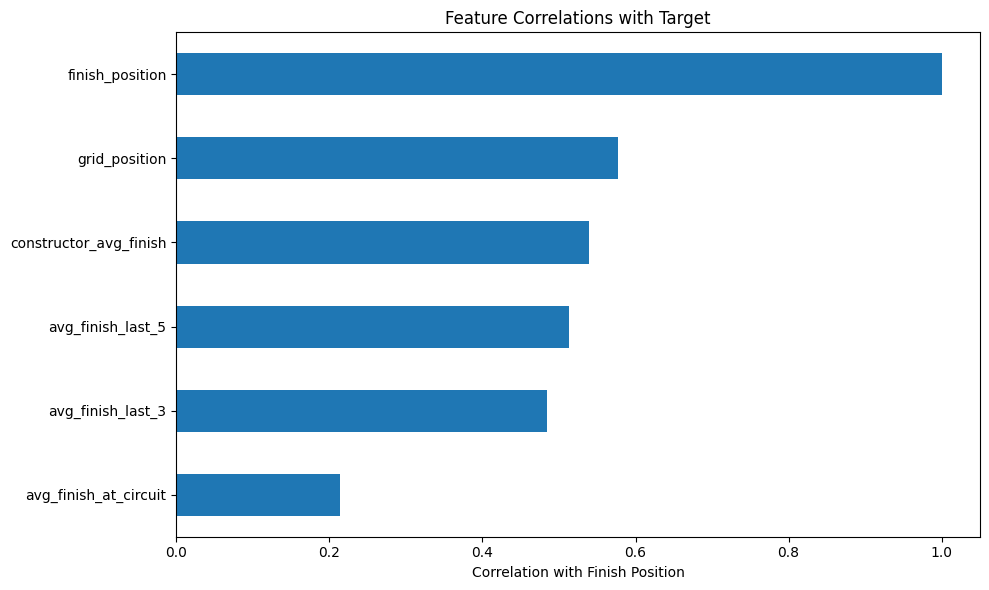

In [15]:
# Visualize Correlations
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
correlations[:-1].sort_values().plot(kind='barh')
plt.xlabel('Correlation with Finish Position')
plt.title('Feature Correlations with Target')
plt.tight_layout()
plt.show()


In [17]:
# newly added featues
df.to_csv('../data/processed/features_complete.csv', index=False)
print(f"Saved complete feature set: {len(df)} rows")
print(f"Features: {feature_columns}")

Saved complete feature set: 10494 rows
Features: ['grid_position', 'avg_finish_last_3', 'avg_finish_last_5', 'avg_finish_at_circuit', 'constructor_avg_finish', 'points_before_race']
